In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
from sklearn import linear_model
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices',con=engine)
engine.dispose()
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
dummies = pd.get_dummies(house_df[['mszoning', 'street', 'lotshape', 'utilities', 'salecondition']])
dummies['saleprice'] = house_df['saleprice']
dummies.corr()['saleprice']

mszoning_C (all)        -0.111257
mszoning_FV              0.089950
mszoning_RH             -0.065429
mszoning_RL              0.245063
mszoning_RM             -0.288065
street_Grvl             -0.041036
street_Pave              0.041036
lotshape_IR1             0.223284
lotshape_IR2             0.126096
lotshape_IR3             0.036720
lotshape_Reg            -0.267672
utilities_AllPub         0.014314
utilities_NoSeWa        -0.014314
salecondition_Abnorml   -0.118069
salecondition_AdjLand   -0.050686
salecondition_Alloca    -0.015525
salecondition_Family    -0.046480
salecondition_Normal    -0.153990
salecondition_Partial    0.352060
saleprice                1.000000
Name: saleprice, dtype: float64

In [5]:
100*house_df.isnull().sum()/house_df.isnull().count()

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
                   ...    
bedroomabvgr      0.000000
kitchenabvgr      0.000000
kitchenqual       0.000000
totrmsabvgrd      0.000000
functional        0.000000
fireplaces        0.000000
f

lotarea


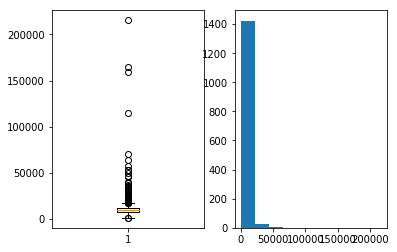

overallqual


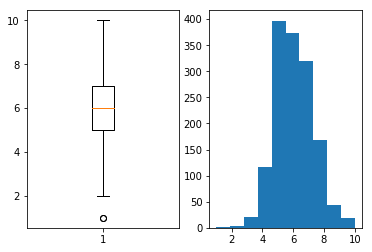

grlivarea


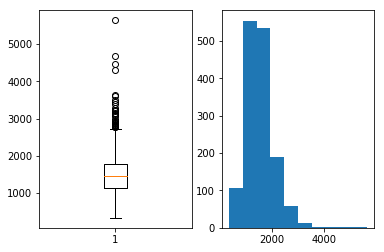

totalbsmtsf


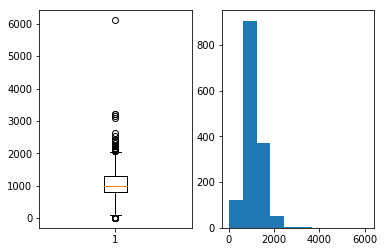

firstflrsf


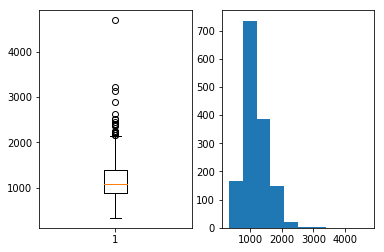

garagecars


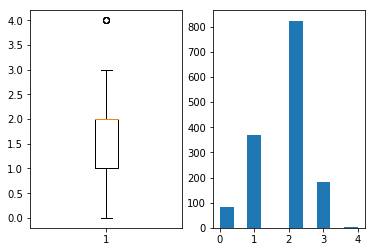

saleprice


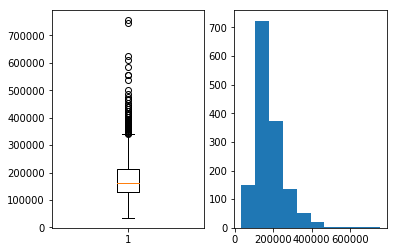

In [6]:
columns = ['lotarea', 'overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'garagecars', 'saleprice']
for col in columns:
    print(col)
    plt.subplot(1,2,1)
    plt.boxplot(house_df[col])
    plt.subplot(1,2,2)
    plt.hist(house_df[col])
    plt.show()

In [7]:
#Here I'm removing all rows that have values in the relevant columns that fall outside of three standard deviations of the mean. In all of these categories, the
#extreme values which appear most often are far above the mean, which indicates houses that are more than likely mansions or farms, meaning that the pricing is not
#going to be helpful in predicting the price of family homes, which operate in a fairly seperate market
for col in columns:
    std = np.std(house_df[col])
    mean = np.mean(house_df[col])
    for i in range(len(house_df[col])):
        if i in house_df.index:
            if(house_df[col][i] >= mean + 3*std):
                house_df = house_df.loc[house_df.index != i]
                print('dropping value at {} because of {}'.format(i, col))
            elif(house_df[col][i] <= mean - 3*std):
                house_df = house_df.loc[house_df.index != i]
                print('dropping value at {} because of {}'.format(i, col))

dropping value at 53 because of lotarea
dropping value at 250 because of lotarea
dropping value at 314 because of lotarea
dropping value at 336 because of lotarea
dropping value at 385 because of lotarea
dropping value at 452 because of lotarea
dropping value at 458 because of lotarea
dropping value at 661 because of lotarea
dropping value at 706 because of lotarea
dropping value at 769 because of lotarea
dropping value at 848 because of lotarea
dropping value at 1298 because of lotarea
dropping value at 1396 because of lotarea
dropping value at 376 because of overallqual
dropping value at 533 because of overallqual
dropping value at 119 because of grlivarea
dropping value at 186 because of grlivarea
dropping value at 198 because of grlivarea
dropping value at 305 because of grlivarea
dropping value at 497 because of grlivarea
dropping value at 523 because of grlivarea
dropping value at 608 because of grlivarea
dropping value at 635 because of grlivarea
dropping value at 691 because of

lotarea


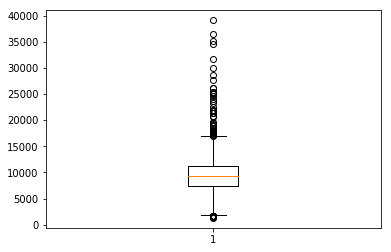

overallqual


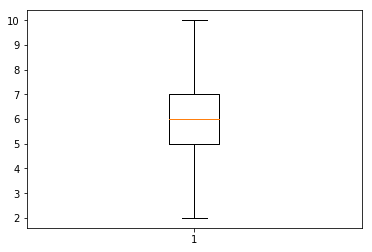

grlivarea


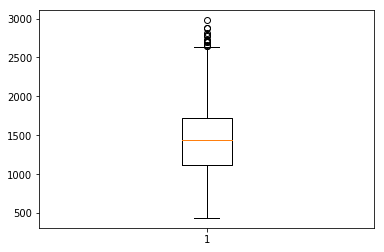

totalbsmtsf


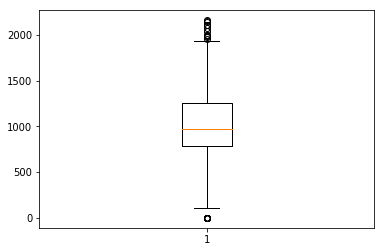

firstflrsf


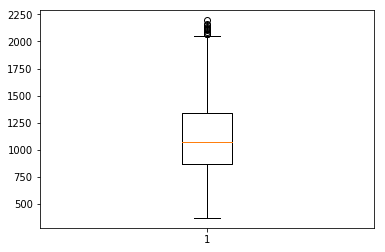

garagecars


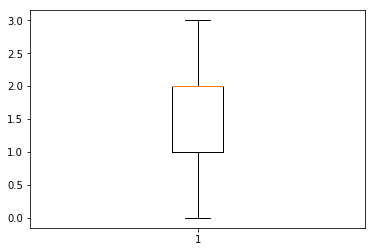

saleprice


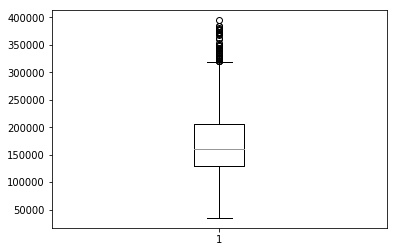

In [8]:
columns = ['lotarea', 'overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'garagecars', 'saleprice']
for col in columns:
    print(col)
    plt.boxplot(house_df[col])
    plt.show()

In [9]:
house_df = pd.concat([house_df, dummies['salecondition_Partial']], axis = 1)

In [10]:
for col in ['saleprice', 'lotarea', 'overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'garagecars', 'salecondition_Partial']:
    house_df = house_df.loc[house_df[col].notnull()]
Y = house_df['saleprice']
X = house_df[['lotarea', 'overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'garagecars', 'salecondition_Partial']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

lotarea


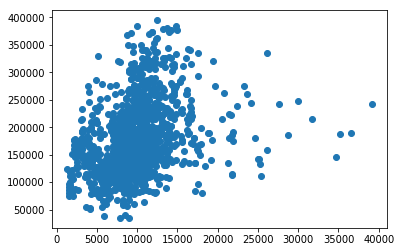

overallqual


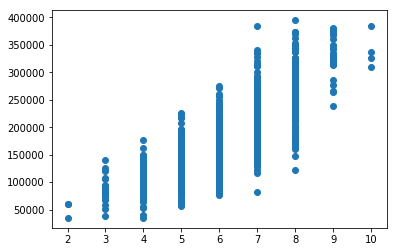

grlivarea


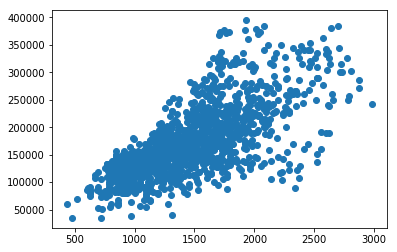

totalbsmtsf


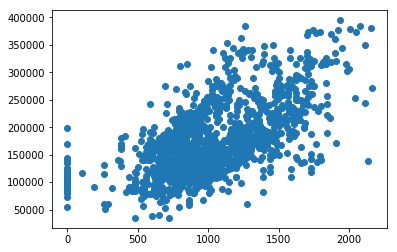

firstflrsf


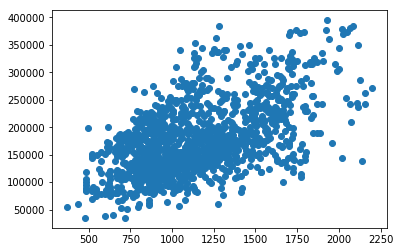

garagecars


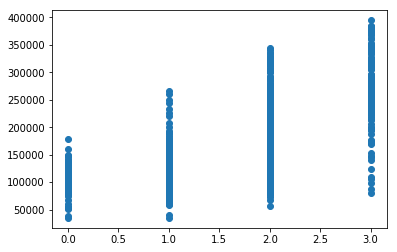

salecondition_Partial


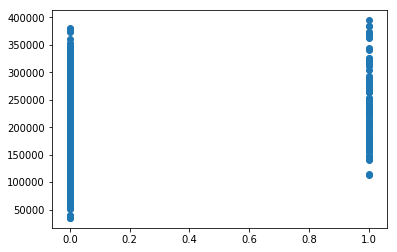

interest rate


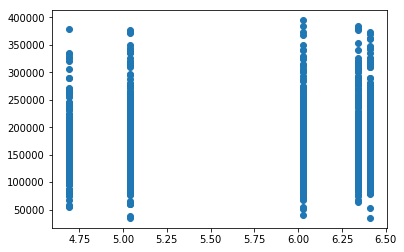

inflation adjusted


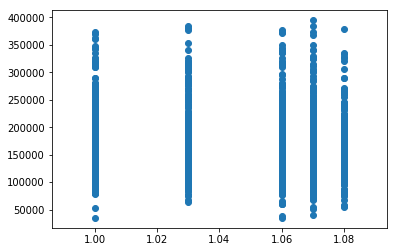

In [24]:
for col in X.columns:
    print(col)
    plt.scatter(X[col], Y)
    plt.show()

In [11]:
lrm = linear_model.LinearRegression()
lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8119925516614566
-----Test set statistics-----
R-squared of the model in the test set is: 0.8553519453074641
Mean absolute error of the prediction is: 16659.966817826946
Mean squared error of the prediction is: 524863976.29207784
Root mean squared error of the prediction is: 22909.910001832784
Mean absolute percentage error of the prediction is: 10.89734642772873


In [27]:
from sklearn.linear_model import Ridge
best_r2 = 0
best_alpha = 1
for x in range(1,8):
    ridgeregr = Ridge(alpha=10**x) 
    ridgeregr.fit(X_train, y_train)
    if(ridgeregr.score(X_train, y_train) > best_r2):
        best_alpha = x
        best_r2 = ridgeregr.score(X_train, y_train) > best_r2

ridgeregr = Ridge(alpha=10**best_alpha)
print(best_alpha)
ridgeregr.fit(X_train, y_train)
y_preds_train = ridgeregr.predict(X_train)
print(y_preds_train)
y_preds_test = ridgeregr.predict(X_test)
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

1
[281213.95452784 211715.10513777 235066.63941293 ... 109387.6667792
 193106.9105765  173940.57475606]
R-squared of the model on the training set is: 0.8222674533201049
-----Test set statistics-----
R-squared of the model on the test set is: 0.8092899278523775
Mean absolute error of the prediction is: 20410.851437897392
Mean squared error of the prediction is: 729794647.4114493
Root mean squared error of the prediction is: 27014.711684773712
Mean absolute percentage error of the prediction is: 13.709758810918402


In [28]:
from sklearn.linear_model import Lasso

best_r2 = 0
best_alpha = 1
for x in range(1,8):
    lassoregr = Lasso(alpha=10**x) 
    lassoregr.fit(X_train, y_train)
    if(lassoregr.score(X_train, y_train) > best_r2):
        best_alpha = x
        best_r2 = lassoregr.score(X_train, y_train) > best_r2

print(best_alpha)
lassoregr = Lasso(alpha=10**best_alpha) 
lassoregr.fit(X_train, y_train)
print(lassoregr.coef_)
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


1
[1.56277342e+00 2.11967322e+04 4.12375352e+01 3.06627195e+01
 2.62606251e+00 1.23172763e+04 1.88217383e+04 1.51282320e+03
 4.07250659e+04]
R-squared of the model on the training set is: 0.8226835576340182
-----Test set statistics-----
R-squared of the model on the test set is: 0.8091178873807221
Mean absolute error of the prediction is: 20454.46224863173
Mean squared error of the prediction is: 730452998.6665165
Root mean squared error of the prediction is: 27026.893988516633
Mean absolute percentage error of the prediction is: 13.73381462441993


In [29]:
from sklearn.linear_model import ElasticNet

best_r2 = 0
best_alpha = 1
for x in range(1,8):
    elasticregr = ElasticNet(alpha=10**x) 
    elasticregr.fit(X_train, y_train)
    if(elasticregr.score(X_train, y_train) > best_r2):
        best_alpha = x
        best_r2 = elasticregr.score(X_train, y_train) > best_r2

print(best_alpha)
elasticregr = ElasticNet(alpha=10**best_alpha, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
y_preds_train

1
R-squared of the model on the training set is: 0.7046630508413759
-----Test set statistics-----
R-squared of the model on the test set is: 0.6932382146524225
Mean absolute error of the prediction is: 24812.257047719584
Mean squared error of the prediction is: 1173892424.5372274
Root mean squared error of the prediction is: 34262.11354451484
Mean absolute percentage error of the prediction is: 16.502985886589812


array([270763.24453474, 210685.04543362, 244098.39190789, ...,
       116832.85390874, 166087.93777322, 181837.1730316 ])

In [15]:
house_df['yrsold'].unique()

array([2008., 2007., 2006., 2009., 2010.])

In [16]:
#These are the external variables I am including in my model
#Adding them allows the model to account for the fact that the value of the dollar is different depending on the time at which the house was sold and account for trends in the overall housing market
interest_rates = [6.41, 6.34, 6.03, 5.04, 4.69]
inflation_adjusted = [1, 1.03, 1.07, 1.06, 1.08]
i_r = []
i_a = []
for i in house_df.index:
    if(house_df['yrsold'][i] == 2006):
        index = 0
    elif(house_df['yrsold'][i] == 2007):
        index = 1
    elif(house_df['yrsold'][i] == 2008):
        index = 2
    elif(house_df['yrsold'][i] == 2009):
        index = 3
    else:
        index = 4
    i_r.append(interest_rates[index])
    i_a.append(inflation_adjusted[index])
house_df['interest rate'] = i_r
house_df['inflation adjusted'] = i_a

In [17]:
house_df[['saleprice', 'interest rate', 'inflation adjusted']].corr()

,saleprice,interest rate,inflation adjusted
saleprice,1.000000,0.038069,-0.032461
interest rate,0.038069,1.000000,-0.731184
inflation adjusted,-0.032461,-0.731184,1.000000


In [20]:
Y = house_df['saleprice']
X = house_df[['lotarea', 'overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'garagecars', 'salecondition_Partial', 'interest rate', 'inflation adjusted']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [21]:
lrm = linear_model.LinearRegression()
lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8227549601275139
-----Test set statistics-----
R-squared of the model in the test set is: 0.8088643156742082
Mean absolute error of the prediction is: 20465.436697313962
Mean squared error of the prediction is: 731423347.3852017
Root mean squared error of the prediction is: 27044.83957033581
Mean absolute percentage error of the prediction is: 13.739836883119185


In [22]:
from sklearn.linear_model import Ridge

ridgeregr = Ridge(alpha=10**2) 
ridgeregr.fit(X_train, y_train)

y_preds_train = ridgeregr.predict(X_train)
print(y_preds_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

[281422.76169519 212549.61271691 236692.75021508 ... 110326.93271916
 191859.39887868 175034.81462409]
R-squared of the model on the training set is: 0.8196369929618565
-----Test set statistics-----
R-squared of the model on the test set is: 0.806935604303333
Mean absolute error of the prediction is: 20287.108627960613
Mean squared error of the prediction is: 738803991.8315884
Root mean squared error of the prediction is: 27180.949060538493
Mean absolute percentage error of the prediction is: 13.63613097160533


The best model type is Linear Regression or Ridge, and the correlations between saleprice and the interest rates and inflation adjusted value of the dollar at the time of sale are too low to be useful features, but incorporating them in the model does reduce some of the fitting issues, so their value is debatable.